In [3]:
import jax
import jax.numpy as jnp
import flox

In [4]:
from flox.util import key_chain


seed = 42
chain = key_chain(42)

In [5]:
dim = 2
num_particles = 100

dmin = 0.1

In [6]:
from functools import partial
from flox.geom import Torus

torus = Torus(jnp.ones(dim))

sigma = jnp.power(2, 1./6.) * dmin
soften = 1e-5

lennard_jones_potential = flox.bulk.pairwise_penalty(
    partial(flox.bulk.lennard_jones_edge, sigma=sigma, soften=soften),
    torus
)

In [7]:
from jax_dataclasses import pytree_dataclass

from jaxtyping import Float, Array

from flox._src.flow.api import Transformed  # type: ignore

Particles = Float[Array, "P D"]
Auxiliaries = Float[Array, "P F"]

@pytree_dataclass(frozen=True)
class State:
    p: jnp.ndarray
    q0: jnp.ndarray
    q1: jnp.ndarray


def sample_base(key, num_particles, dim):
    chain = key_chain(key)
    p = jax.random.uniform(next(chain), shape=(num_particles, dim))
    q0 = jax.random.normal(next(chain), shape=(num_particles, 1, dim))
    q1 = jax.random.normal(next(chain), shape=(num_particles, 1, dim))
    ldj = harmonic(q0) + harmonic(q1)
    return Transformed(State(p, q0, q1), ldj)


def harmonic(x):
    return jnp.sum(0.5 * jnp.square(x))


def base_potential(s: State):
    return harmonic(s.q0) + harmonic(s.q1)


def target_potential(s: State):
    return lennard_jones_potential(s.p) + harmonic(s.q0) + harmonic(s.q1)

In [8]:
resolution = (32, 32)

In [9]:
from typing import cast
import haiku as hk

from flox._src.bulk.lattice import AggregationMethod, neighbors

def indices_and_weights(pos, resolution):
    idx = jax.vmap(flox.bulk.lattice_indices, in_axes=(0, None, None))(pos, flox.bulk.neighbors(pos.shape[-1]), resolution)
    weights = jax.vmap(flox.bulk.lattice_weights, in_axes=(0, 0, None))(pos, idx, resolution)
    return idx, weights


class GaugeConvNet(hk.Module):

    def __init__(self, num_out, resolution):
        super().__init__()
        self.num_out = num_out
        self.resolution = resolution

    def __call__(self, idx, weights, sig):
        dim = sig.shape[-1]
        kernel = hk.get_parameter(
            "kernel",
            shape=(3 ** dim, sig.shape[-2], self.num_out),
            init=hk.initializers.TruncatedNormal()
        )
        # bias = hk.get_parameter(
        #     "bias", shape=(self.num_out, 1),
        #     init=hk.initializers.Constant(0.)
        # )
        sig = flox.bulk.scatter(sig, weights, idx, self.resolution)
        other = flox.bulk.gather(sig, idx, AggregationMethod.Nothing)
        focus = cast(Array, other[:, 4])
        out = jax.vmap(flox.bulk.gauge_conv, in_axes=(0, 0, None, None))(
            focus, other, neighbors(dim), kernel
        ) #+ bias
        return out


class Linear(hk.Module):
    
    def __init__(self, num_out):
        super().__init__()
        self.num_out = num_out

    def __call__(self, x):
        stddev = 1./jnp.sqrt(x.shape[-2] + self.num_out)
        w = hk.get_parameter(
            "weight",
            shape=(x.shape[-2], self.num_out),
            init=hk.initializers.TruncatedNormal(stddev=stddev))
        return jnp.einsum("...fd, fg -> ...gd", x, w)


class GaugeResNet(hk.Module):

    def __init__(self, num_layers, num_hidden, num_out, resolution, activation, output_residual):
        super().__init__()
        self.num_hidden = num_hidden
        self.resolution = resolution
        self.activation = activation
        self.num_layers = num_layers
        self.num_out = num_out
        self.output_residual = output_residual

    def __call__(self, idx, weights, signal):
        def body(signal) -> Array:
            out = GaugeConvNet(self.num_hidden, self.resolution)(idx, weights, signal)
            return signal + self.activation(out)

        out = Linear(self.num_hidden)(signal)
        out = hk.experimental.layer_stack(self.num_layers)(body)(out)
        out = Linear(self.num_out)(out)
        if self.output_residual:
            if signal.shape[-2] in (self.num_out, 1):
                return signal + out
            else:
                raise ValueError(f"Cannot broadcast output residual."\
                                 f"Input channels: {signal.shape[-2]}, "\
                                 f"Oututput channels: {self.num_out}.")
        else:
            return signal

In [10]:

from flox._src.flow.api import Transformed
from flox._src.geom.manifold import Manifold, PointN
from flox.flow import Affine, Lambda

def indices_and_weights(pos, resolution):
    idx = jax.vmap(flox.bulk.lattice_indices, in_axes=(0, None, None))(pos, flox.bulk.neighbors(pos.shape[-1]), resolution)
    weights = jax.vmap(flox.bulk.lattice_weights, in_axes=(0, 0, None))(pos, idx, resolution)
    return idx, weights

class AuxUpdater(hk.Module):

    def __init__(self, field, num_layers, num_hidden, num_out, resolution, activation):
        super().__init__()
        self.field = field
        self.num_layers = num_layers
        self.num_hidden = num_hidden
        self.num_out = num_out
        self.resolution = resolution
        self.activation = activation

    def __call__(self, state: State):
        idx, weights = indices_and_weights(state.p, self.resolution)
        params = GaugeResNet(
            self.num_layers,
            self.num_hidden,
            self.num_out,
            self.resolution,
            self.activation,
            True
        )(idx, weights, self.field(state))
        shift, scale = jnp.split(params, 2, axis=-2)
        shift = shift.sum(axis=-2, keepdims=True) * 1e-4
        scale = jnp.sqrt(1e-12 + jnp.square(scale.sum(axis=-2, keepdims=True)).sum(axis=-1, keepdims=True)) * 1e-4
        return Affine(shift, scale)

class PosUpdater(hk.Module):

    def __init__(self, manifold: Manifold, init_scale: float=1e-3):
        super().__init__()
        self.manifold = manifold
        self.init_scale = init_scale

    def __call__(self, state: State) -> Lambda[PointN, PointN]:
        shift = state.q0.sum(axis=-2) * self.init_scale
        
        def shift_fn(x, shift) -> Transformed[PointN]:
            return Transformed(self.manifold.shift(x, shift), jnp.zeros(()))
        
        return Lambda(
            forward=lambda x: shift_fn(x, shift),
            inverse=lambda x: shift_fn(x, -shift)
        )

In [11]:
from functools import partial

relax = flox.bulk.relax(
    torus.shift,
    flox.bulk.pairwise_penalty(
        partial(flox.bulk.soft_edge, dmin=dmin),
        torus
    )
)

In [12]:
import haiku as hk
import lenses
from flox._src.flow.api import Transform
from flox._src.flow.impl import Affine
from flox._src.util.func import Lens
from flox.bulk import gauge_conv
import flox.nn as fnn

class Relaxation(hk.Module):
    def __call__(self, s: State):
        _, dq = relax(s.p)
        dq = dq[..., None, :]
        return Affine(dq, jnp.zeros_like(dq))


def get_q0(state: State):
    return state.q0

def update_q0(state: State, new):
    return lenses.bind(state).q0.set(new)

def get_q1(state: State):
    return state.q1

def update_q1(state: State, new):
    return lenses.bind(state).q1.set(new)

def get_pos(state: State):
    return state.p

def update_pos(state: State, new):
    return lenses.bind(state).p.set(new)


def make_aux_coupling() -> Transform[State, State]:
    return flox.flow.Pipe([
        flox.flow.SimpleCoupling(
            AuxUpdater(
                get_q0,
                2, 64, 2, (32, 32), jax.nn.silu,
            ),
            Lens(get_q1, update_q1)
        ),
        flox.flow.SimpleCoupling(
            AuxUpdater(
                get_q1,
                2, 64, 2, (32, 32), jax.nn.silu,
            ),
            Lens(get_q0, update_q0)
        )

    ])

def make_inner_flow(num_blocks) -> Transform[State, State]:
    return flox.flow.Pipe([
        flox.nn.haiku.LayerStack(make_aux_coupling, num_layers=num_blocks),
        flox.flow.SimpleCoupling(
            PosUpdater(torus),
            Lens(get_pos, update_pos)
        )
    ])

def make_full_flow(num_blocks) -> Transform[State, State]:
    return flox.flow.Pipe([
        flox.flow.SimpleCoupling(
            Relaxation(),
            Lens(get_q0, update_q0)
        ),
        make_inner_flow(num_blocks),
    ])

flow = flox.nn.haiku.to_haiku(partial(make_full_flow, num_blocks=2))

In [13]:
from flox.flow import Transformed 

num_particles = 100

p = jax.random.uniform(next(chain), shape=(num_particles, dim))
q0 = jax.random.normal(next(chain), shape=(num_particles, 1, dim)) * 1e-3
q1 = jax.random.normal(next(chain), shape=(num_particles, 1, dim)) * 1e-3

params = jax.jit(flow.pure.init)(
    next(chain),
    State(p, q0, q1)
)

In [14]:
p = jax.random.uniform(next(chain), shape=(num_particles, dim))
q0 = jax.random.normal(next(chain), shape=(num_particles, 1, dim)) * 1e-3
q1 = jax.random.normal(next(chain), shape=(num_particles, 1, dim)) * 1e-3

out = jax.jit(flow.with_params(params).forward)(
    State(p, q0, q1)
)



In [15]:
import optax

NUM_ITERS = 3_000
PLOT_INTERVAL = 50
LEARNING_RATE = 1e-4

optim = optax.adam(learning_rate=LEARNING_RATE)
opt_state = optim.init(params)

In [16]:
from flox.nn import train
from flox.flow import DatasetSampler

step = train.mle_step(base_potential, flow, optim, partial(sample_base, num_particles=num_particles, dim=dim), 128)
step = jax.jit(step)

In [17]:
import time

from IPython import display  # type: ignore
from IPython.display import clear_output
from matplotlib import pyplot as plt  # type: ignore
from tqdm import tqdm

pbar = tqdm(range(NUM_ITERS))
agg_loss = train.RunningMean(0., 0)
losses = []


for i in pbar:
    
    loss, params, opt_state = step(next(chain), params, opt_state)  # type: ignore
    agg_loss = agg_loss.update(loss)
    losses.append(agg_loss.value)
    
    pbar.set_description(f"loss: {agg_loss.value:.4}")
    if not i % PLOT_INTERVAL:
        
        display.clear_output(wait=True)
        plt.plot(losses)
        plt.ylabel("NLL")
        plt.xlabel("#iters")
    
        plt.show()
        time.sleep(0.001)

  0%|                                                                                                                                               | 0/3000 [00:00<?, ?it/s]2022-11-08 18:39:05.778271: W external/org_tensorflow/tensorflow/tsl/framework/bfc_allocator.cc:479] Allocator (GPU_0_bfc) ran out of memory trying to allocate 7.19GiB (rounded to 7725497856)requested by op 
2022-11-08 18:39:05.778537: W external/org_tensorflow/tensorflow/tsl/framework/bfc_allocator.cc:492] *___________________________________________________________________________________________________
2022-11-08 18:39:05.781858: E external/org_tensorflow/tensorflow/compiler/xla/pjrt/pjrt_stream_executor_client.cc:2153] Execution of replica 0 failed: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 7725497712 bytes.
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:    3.38MiB
              constant allocation:       172B
        maybe_live_out allocation:    3.3

XlaRuntimeError: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 7725497712 bytes.
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:    3.38MiB
              constant allocation:       172B
        maybe_live_out allocation:    3.38MiB
     preallocated temp allocation:    7.19GiB
                 total allocation:    7.20GiB
Peak buffers:
	Buffer 1:
		Size: 1.10GiB
		XLA Label: copy
		Shape: s32[2,2,128,100,9,64,2,5]
		==========================

	Buffer 2:
		Size: 1.10GiB
		Operator: op_name="jit(jitted_step)/jit(main)/jit(jitted_step)/jvp(vmap(inverse))/stacked/_apply/stacked/layer_stack/broadcast_in_dim[shape=(2, 2, 128, 100, 9, 64, 2, 5) broadcast_dimensions=()]" source_file="/storage/mi/jonkhler/miniconda3/envs/py310/lib/python3.10/site-packages/haiku/_src/layer_stack.py" source_line=121
		XLA Label: broadcast
		Shape: s32[2,2,128,100,9,64,2,5]
		==========================

	Buffer 3:
		Size: 450.00MiB
		XLA Label: copy
		Shape: s32[2,2,128,100,9,64,4]
		==========================

	Buffer 4:
		Size: 450.00MiB
		Operator: op_name="jit(jitted_step)/jit(main)/jit(jitted_step)/jvp(vmap(inverse))/stacked/_apply/stacked/layer_stack/broadcast_in_dim[shape=(2, 2, 128, 100, 9, 64, 4) broadcast_dimensions=()]" source_file="/storage/mi/jonkhler/miniconda3/envs/py310/lib/python3.10/site-packages/haiku/_src/layer_stack.py" source_line=121
		XLA Label: fusion
		Shape: s32[2,2,128,100,9,64,4]
		==========================

	Buffer 5:
		Size: 225.00MiB
		XLA Label: copy
		Shape: f32[2,2,128,100,9,64,2]
		==========================

	Buffer 6:
		Size: 225.00MiB
		XLA Label: copy
		Shape: f32[2,2,128,100,9,64,2]
		==========================

	Buffer 7:
		Size: 225.00MiB
		XLA Label: copy
		Shape: f32[2,2,128,100,9,64,2]
		==========================

	Buffer 8:
		Size: 225.00MiB
		Operator: op_name="jit(jitted_step)/jit(main)/jit(jitted_step)/jvp(vmap(inverse))/stacked/_apply/stacked/layer_stack/broadcast_in_dim[shape=(2, 2, 128, 100, 9, 64, 2) broadcast_dimensions=()]" source_file="/storage/mi/jonkhler/miniconda3/envs/py310/lib/python3.10/site-packages/haiku/_src/layer_stack.py" source_line=121
		XLA Label: broadcast
		Shape: f32[2,2,128,100,9,64,2]
		==========================

	Buffer 9:
		Size: 112.50MiB
		XLA Label: copy
		Shape: f32[2,2,128,100,9,64]
		==========================

	Buffer 10:
		Size: 112.50MiB
		Operator: op_name="jit(jitted_step)/jit(main)/jit(jitted_step)/jvp(vmap(inverse))/stacked/_apply/stacked/layer_stack/broadcast_in_dim[shape=(2, 2, 128, 100, 9, 64) broadcast_dimensions=()]" source_file="/storage/mi/jonkhler/miniconda3/envs/py310/lib/python3.10/site-packages/haiku/_src/layer_stack.py" source_line=121
		XLA Label: broadcast
		Shape: f32[2,2,128,100,9,64]
		==========================

	Buffer 11:
		Size: 56.25MiB
		Operator: op_name="jit(jitted_step)/jit(main)/jit(jitted_step)/gauge_conv_net/broadcast_in_dim[shape=(128, 100, 9, 64, 2, 1) broadcast_dimensions=(1, 2, 3, 4, 5)]" source_file="/storage/mi/jonkhler/PhD/flox/flox/_src/bulk/convolution.py" source_line=231
		XLA Label: iota
		Shape: s32[128,100,9,64,2,1]
		==========================

	Buffer 12:
		Size: 56.25MiB
		Operator: op_name="jit(jitted_step)/jit(main)/jit(jitted_step)/gauge_conv_net/broadcast_in_dim[shape=(128, 100, 9, 64, 2, 1) broadcast_dimensions=(1, 2, 3, 4, 5)]" source_file="/storage/mi/jonkhler/PhD/flox/flox/_src/bulk/convolution.py" source_line=231
		XLA Label: iota
		Shape: s32[128,100,9,64,2,1]
		==========================

	Buffer 13:
		Size: 56.25MiB
		Operator: op_name="jit(jitted_step)/jit(main)/jit(jitted_step)/gauge_conv_net/broadcast_in_dim[shape=(128, 100, 9, 64, 2, 1) broadcast_dimensions=(1, 2, 3, 4, 5)]" source_file="/storage/mi/jonkhler/PhD/flox/flox/_src/bulk/convolution.py" source_line=231
		XLA Label: iota
		Shape: s32[128,100,9,64,2,1]
		==========================

	Buffer 14:
		Size: 56.25MiB
		Operator: op_name="jit(jitted_step)/jit(main)/jit(jitted_step)/gauge_conv_net/iota[dtype=int32 shape=(128, 100, 9, 64, 2, 1) dimension=0]" source_file="/storage/mi/jonkhler/PhD/flox/flox/_src/bulk/convolution.py" source_line=231
		XLA Label: iota
		Shape: s32[128,100,9,64,2,1]
		==========================

	Buffer 15:
		Size: 56.25MiB
		Operator: op_name="jit(jitted_step)/jit(main)/jit(jitted_step)/gauge_conv_net/broadcast_in_dim[shape=(128, 100, 2, 9, 64) broadcast_dimensions=(1, 2, 3, 4)]" source_file="/storage/mi/jonkhler/PhD/flox/flox/_src/bulk/convolution.py" source_line=230
		XLA Label: fusion
		Shape: f32[128,100,2,9,64]
		==========================



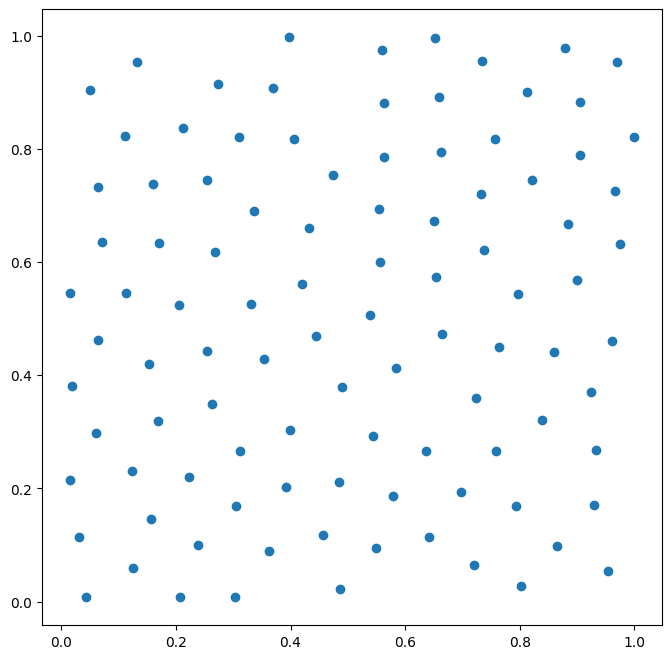

: 

: 

In [ ]:
from matplotlib import pyplot as plt


plt.figure(figsize=(8, 8))
plt.scatter(*out.obj.p.T)

: 

: 